# Imports

In [1]:
import mdtraj as md
import matplotlib.pyplot as plt
import os, sys
repo_path = f"../../"
sys.path.append(repo_path)
from enhanced_sampling import (utils,
                               system_building as sb,
                               system_saving as ss,
                               reporters,
                               cv_building as cv,
                               schema)
from importlib import reload

# Loading Files

In [42]:
fwd_path = "../systems/eBDims/transition_forward.pdb"
rev_path = "../systems/eBDims/transition_reverse.pdb"

In [43]:
fwd = md.load(fwd_path)
rev = md.load(rev_path)

In [4]:
fwd

<mdtraj.Trajectory with 46 frames, 894 atoms, 894 residues, without unitcells at 0x17e933f40>

In [5]:
rev

<mdtraj.Trajectory with 43 frames, 894 atoms, 894 residues, without unitcells at 0x17e5b0e50>

# Plotting RMSD

In [6]:
fwd_rmsd = md.rmsd(fwd, rev)*10
rev_rmsd = md.rmsd(rev, fwd)*10

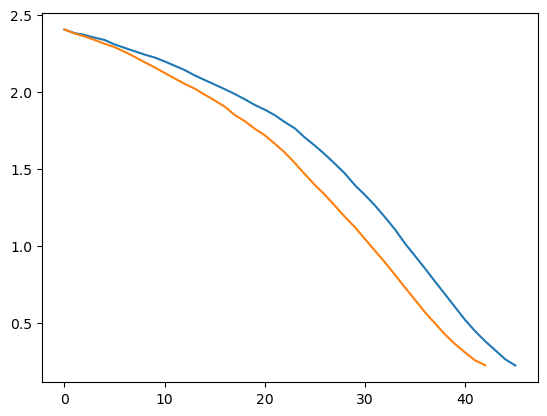

In [7]:
plt.plot(fwd_rmsd)
plt.plot(rev_rmsd)

# Test getting positions

In [8]:
len(fwd.xyz[0])

894

In [9]:
fwd.xyz[0]

array([[-1.5793759e+00, -7.4008268e-01, -2.0439115e+00],
       [-1.3379759e+00, -5.2228266e-01, -1.8314114e+00],
       [-9.5417583e-01, -4.9118266e-01, -1.7904112e+00],
       ...,
       [-4.2232757e+00, -8.2673803e-05, -1.7515113e+00],
       [-4.5359759e+00, -2.1668267e-01, -1.7358115e+00],
       [-4.6746759e+00, -4.2982675e-02, -1.4241114e+00]], dtype=float32)

In [10]:
len(fwd.xyz)

46

# Load system

In [11]:
input_dict = sb.load_input_dir('../systems/system00/')

Loading psf from ../systems/system00/step5_input.psf


In [12]:
psf = input_dict["psf"]

In [13]:
reload(sb)

<module 'enhanced_sampling.system_building' from '/Users/alexpayne/Scientific_Projects/enhanced-sampling-tmem175/enhanced_sampling/system_building.py'>

In [14]:
open_input = sb.load_input_dir('../systems/system00/', from_state=True, from_pdb=True)

Loading psf from ../systems/system00/step5_input.psf


In [15]:
pdb = md.load("../systems/system00/step5_input.pdb")

In [16]:
fwd

<mdtraj.Trajectory with 46 frames, 894 atoms, 894 residues, without unitcells at 0x17e933f40>

In [17]:
pdb_cas = pdb.atom_slice(pdb.topology.select("protein and name CA"))

In [18]:
pdb_cas

<mdtraj.Trajectory with 1 frames, 894 atoms, 894 residues, without unitcells at 0x18105cdf0>

In [19]:
md.rmsd(fwd, pdb_cas)

array([0.24070384, 0.2383621 , 0.23719524, 0.23539928, 0.2339073 ,
       0.23100792, 0.22875318, 0.22657968, 0.22436808, 0.22249314,
       0.21995264, 0.21714616, 0.21432588, 0.21087568, 0.20786265,
       0.20493594, 0.20193438, 0.19879963, 0.19539952, 0.19168292,
       0.18859498, 0.18507533, 0.18054906, 0.17654791, 0.17056555,
       0.16532972, 0.15967308, 0.15360598, 0.1472113 , 0.13967606,
       0.13335066, 0.12655458, 0.11887706, 0.11094914, 0.1018746 ,
       0.09376165, 0.08561993, 0.07724264, 0.06895656, 0.06063709,
       0.05239351, 0.04511154, 0.03857179, 0.03291828, 0.02707338,
       0.02308826], dtype=float32)

# Test using CA for force

## get ca positions

In [20]:
idx_list = cv.get_openmm_idx(psf.topology, selection="protein_ca")

Using protein selection: protein_ca and res_list: False


In [21]:
len(idx_list)

894

## get ref positions

In [22]:
ref_positions = fwd.xyz[1]

In [23]:
restraint_positions = {idx_list[i]: ref_positions[i] for i in range(len(idx_list))}

In [24]:
x,y,z = restraint_positions[8]

In [25]:
force = cv.create_harmonic_pulling_force(restraint_positions, 100)

In [26]:
force.setForceGroup(20)
print(f"Adding {force.getName()} to system with {force.getNumParticles()} particles")

Adding CustomExternalForce to system with 894 particles


# Test superposing ebdims

In [27]:
fwd

<mdtraj.Trajectory with 46 frames, 894 atoms, 894 residues, without unitcells at 0x17e933f40>

In [28]:
cas = pdb.topology.select("protein and name CA")

In [29]:
len(cas)

894

In [30]:
fwd_superpose = fwd.superpose(reference = pdb,
                              frame=0,
                              atom_indices=fwd.topology.select("protein and name CA"),
                              ref_atom_indices=pdb.topology.select("protein and name CA")
                             )

In [31]:
fwd_superpose.xyz[0][0]

array([4.482907 , 5.310242 , 3.2695339], dtype=float32)

In [32]:
fwd.xyz[0][0]

array([4.482907 , 5.310242 , 3.2695339], dtype=float32)

In [33]:
fwd_superpose

<mdtraj.Trajectory with 46 frames, 894 atoms, 894 residues, without unitcells at 0x17e933f40>

In [34]:
fwd_superpose.save("../systems/eBDims/closed_to_open_superposed.pdb")

In [35]:
md.rmsd(fwd_superpose, pdb_cas)

array([0.24070612, 0.23835981, 0.23719984, 0.23539928, 0.23390496,
       0.23101029, 0.22875318, 0.22657003, 0.22436808, 0.22249068,
       0.21994768, 0.2171512 , 0.21432588, 0.21088086, 0.20786265,
       0.20493594, 0.20192896, 0.19880511, 0.19539392, 0.19168292,
       0.18859209, 0.18507533, 0.18055813, 0.17655101, 0.17055593,
       0.16533634, 0.15966965, 0.15360244, 0.14721501, 0.13967606,
       0.13335474, 0.12654163, 0.11889084, 0.11094422, 0.10186388,
       0.09375583, 0.08561993, 0.07724971, 0.06896448, 0.06063709,
       0.05238308, 0.04511154, 0.03855763, 0.03295144, 0.0270532 ,
       0.0230409 ], dtype=float32)

In [44]:
rev_superpose = rev.superpose(reference = pdb,
                              frame=0,
                              atom_indices=rev.topology.select("protein and name CA"),
                              ref_atom_indices=pdb.topology.select("protein and name CA")
                             )

In [45]:
rev_superpose.xyz[0][0]

array([4.482549 , 5.272369 , 3.3224187], dtype=float32)

In [46]:
rev_superpose.save("../systems/eBDims/open_to_closed_superposed.pdb")

In [47]:
rev_superpose.xyz[0][0]

array([4.482549 , 5.272369 , 3.3224187], dtype=float32)